In [1]:
import os
import cv2
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
os.chdir('F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5/')

detection_model =torch.hub.load('.', 'custom', path='F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3/best.pt', source='local')

recognition_model = torch.hub.load('.', 'custom', path=r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\recognition_model/best.pt', source='local')

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7080247 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


In [3]:
images = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\images/'
cropped_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect'
exp_path = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp'
saved_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_images'
resized_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\resized_images'

In [4]:
def delete_folder_or_file(path):
    folder_path = path.split("\\")
    if "exp" in folder_path:
        shutil.rmtree(path)
    else:
        for img in os.listdir(path):
            img_path = path + "\\" + img
            # Use os.remove() to delete the file
            os.remove(img_path)
    return

In [5]:
def apply_detection_model_and_save_results(model, images_path):
    for img in os.listdir(images):
        try:
            img_path = os.path.join(images_path, img)
            result = model(img_path)
            crops = result.crop(save=True)
        except (OSError, cv2.error) as e:
            print(f"Error processing image {img}: {e}")
            continue

In [6]:
def save_cropped_img(cropped_img_dir, saved_img_dir):
    for filename in os.listdir(cropped_img_dir):
        for crops in os.listdir(os.path.join(cropped_img_dir, filename)):
            if crops == "crops":
                for plate in os.listdir(os.path.join(cropped_img_dir, filename, crops)):
                    for img in os.listdir(os.path.join(cropped_img_dir, filename, crops, plate)):
                        img_path = os.path.join(cropped_img_dir, filename, crops, plate, img)
                        image = cv2.imread(img_path)
                        cv2.imwrite(saved_img_dir + "//" + img, image)
    return

In [7]:
def resize_img(saved_img_dir, resized_img_dir):
    # Create the output folder if it doesn't exist
    os.makedirs(resized_img_dir, exist_ok=True)
    # Iterate over the files in the input folder
    for filename in os.listdir(saved_img_dir):
        input_path = os.path.join(saved_img_dir, filename)
        output_path = os.path.join(resized_img_dir, filename)

        # Check if the file is an image
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Read the image
            image = cv2.imread(input_path)

            # Check if the image was successfully read
            if image is not None:
                ratio = 600 / image.shape[1]
                width = round(image.shape[1] * ratio)
                height = round(image.shape[0] * ratio)

                # Resize the image
                resized_image = cv2.resize(image, (width, height))

                # Save the resized image to the output folder
                cv2.imwrite(output_path, resized_image)
#                 print(f"Resized image saved: {output_path}")
            else:
                print(f"Failed to read image: {input_path}")
        else:
            print(f"Skipping non-image file: {input_path}")

In [8]:
def reverse_labels_and_boxes(img_path):
    for img in os.listdir(img_path):
        image_path = img_path + "\\" + img
    results = recognition_model(image_path)

    # Get the predicted labels and bounding box coordinates
    labels = results.xyxyn[0][:, -1].cpu().numpy()
    boxes = results.xyxyn[0][:, :-1].cpu().numpy()

    # Get the class names associated with the model
    class_names = recognition_model.module.names if hasattr(recognition_model, 'module') else recognition_model.names

    # Reverse the order of labels and bounding boxes
    reversed_labels = labels[::-1]
    reversed_boxes = boxes[::-1]
    return reversed_labels, reversed_boxes, class_names

In [9]:
def return_model_result(reversed_labels, reversed_boxes, class_names):        
        # Initialize an empty dictionary to store the results
        model_result = {}

        # Iterate over the reversed bounding box coordinates and labels
        for label, box in zip(reversed_labels, reversed_boxes):
            # Get the label name using the model's class names
            label_name = class_names[int(label)]

            # Check if the label name already exists in the dictionary
            if label_name in model_result:
                # If the label name exists, append the bounding box to the existing list
                model_result[label_name].append(box[0])
            else:
                # If the label name doesn't exist, create a new list with the bounding box
                model_result[label_name] = [box[0]]

        # Print the model_result dictionary
        return model_result

In [10]:
def return_sorted_plate_characters(reversed_labels, reversed_boxes,class_names, model_result):
    lst = []
    for label, box in zip(reversed_labels, reversed_boxes):
        # Get the label name using the model's class names
        label_name = class_names[int(label)]

        lst.append(box[0])

    lst.sort()  # Sort the list of bounding boxes in ascending order

    # Initialize an empty list to store the matching keys
    matching_keys = []

    # Iterate over the elements in lst
    for item in lst:
        found_match = False
        for key, value in model_result.items():
            if np.allclose(value, item):
                matching_keys.append(key)
                found_match = True
                break
        if not found_match:
            # Check if the item matches any array value element-wise
            for key, value in model_result.items():
                if any(np.allclose(v, item) for v in value):
                    matching_keys.append(key)
                    break

    # Print the matching keys
    return matching_keys

In [11]:
replace_arabic_characters_and_digits = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
                                        "alif":"أ", "baa":"ب", "geem":"ج", "daal":"د", "raa":"ر", "seen":"س", "saad":"ص", "taa":"ط",
                                        "ein":"ع", "faa":"ف", "qaaf":"ق", "laam":"ل", "meem":"م", "noon":"ن", "haa":"ه", "waaw":"و", "yaa":"ي"}

In [12]:
def convert_plate_characters(matching_keys):
    # Initialize an empty list to store the corresponding values
    matching_values = []

    # Iterate over the keys in matching_keys
    for key in matching_keys:
        if key in replace_arabic_characters_and_digits:
            value = replace_arabic_characters_and_digits[key]
            matching_values.append(value)

    # Print the matching values
    return matching_values

In [13]:
def join_digits_and_sort_characters(matching_values):
    numbers = ''
    characters = ''

    for item in matching_values:
        if isinstance(item, int):
            numbers += str(item)
        elif isinstance(item, str):
            characters += item
            separated_characters = list(characters[::-1])

    result_list = [numbers, separated_characters]
    return result_list

In [14]:
# def get_governorate(result_list):
#     replace_first_element = {"س": "الإسكندرية", "ر": "الشرقية", "د": "الدقهلية", "م": "المنوفية", "ب": "البحيرة",
#                              "ل": "كفر الشيخ", "ع": "الغربية", "ق": "القليوبية", "ف": "الفيوم", "و": "بني سويف",
#                              "ن": "المنيا", "ي": "أسيوط", "ه": "سوهاج", "أ": "القاهرة"}

#     replace_second_element_if_first_geem = {"ه": "مطروح", "ب": "الوادي الجديد"}

#     replace_second_element_if_first_saad = {"أ": "قنا", "ق": "الأقصر", "و": "أسوان"}

#     replace_second_element_if_first_taa = {"س": "السويس", "ص": "الاسماعيلية", "ع": "بورسعيد", "د": "دمياط",
#                                            "أ": "شمال سيناء", "ج": "جنوب سيناء", "ر": "البحر الأحمر"}

#     first_char = result_list[1][0]
#     sec_char = result_list[1][1]

#     if len(result_list[0]) == 3 and len(result_list[1]) == 3:
#         value = "القاهرة"
#     elif len(result_list[0]) == 4 and len(result_list[1]) == 2:
#         value = "الجيزة"
#     elif len(result_list[0]) == 4 and len(result_list[1]) == 3:
#         if first_char == "ج":
#             value = replace_second_element_if_first_geem.get(sec_char, "أخرى")
#         elif first_char == "ص":
#             value = replace_second_element_if_first_saad.get(sec_char, "أخرى")
#         elif first_char == "ط":
#             value = replace_second_element_if_first_taa.get(sec_char, "أخرى")
#         else:
#             value = replace_first_element.get(first_char, "أخرى")
#     else:
#         value = "أخرى"
#     return value

In [26]:
def get_governorate(result_list):
    replace_first_element = {"س": "الإسكندرية", "ر": "الشرقية", "د": "الدقهلية", "م": "المنوفية", "ب": "البحيرة",
                             "ل": "كفر الشيخ", "ع": "الغربية", "ق": "القليوبية", "ف": "الفيوم", "و": "بني سويف",
                             "ن": "المنيا", "ي": "أسيوط", "ه": "سوهاج", "أ": "القاهرة"}

    replace_second_element_if_first_geem = {"ه": "مطروح", "ب": "الوادي الجديد"}

    replace_second_element_if_first_saad = {"أ": "قنا", "ق": "الأقصر", "و": "أسوان"}

    replace_second_element_if_first_taa = {"س": "السويس", "ص": "الاسماعيلية", "ع": "بورسعيد", "د": "دمياط",
                                           "أ": "شمال سيناء", "ج": "جنوب سيناء", "ر": "البحر الأحمر"}

    if len(result_list[1]) >= 2:
        first_char = result_list[1][0]
        sec_char = result_list[1][1]

        if len(result_list[0]) == 3 and len(result_list[1]) == 3:
            value = "القاهرة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 2:
            value = "الجيزة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 3:
            if first_char == "ج":
                value = replace_second_element_if_first_geem.get(sec_char, "أخرى")
            elif first_char == "ص":
                value = replace_second_element_if_first_saad.get(sec_char, "أخرى")
            elif first_char == "ط":
                value = replace_second_element_if_first_taa.get(sec_char, "أخرى")
            else:
                value = replace_first_element.get(first_char, "أخرى")
        else:
            value = "أخرى"
    else:
        value = "أخرى"
    
    return value

In [23]:
def append_governorate_to_result_list(result_list, value):
    value = get_governorate(result_list)
    result_list.append(value)
    return result_list

In [27]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir):
    delete_folder_or_file(exp_path)    
    delete_folder_or_file(saved_img_dir)
    delete_folder_or_file(resized_img_dir)
    apply_detection_model_and_save_results(detection_model, images)
    save_cropped_img(cropped_img_dir, saved_img_dir)
    resize_img(saved_img_dir, resized_img_dir)
    reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
    model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
    matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
    matching_values = convert_plate_characters(matching_keys)
    result_list = join_digits_and_sort_characters(matching_values)
    governorate = get_governorate(result_list)
    final_result = append_governorate_to_result_list(result_list, governorate)
    return final_result

In [33]:
final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



In [18]:
%matplotlib inline

In [29]:
def show_image_and_final_result(images):
    print(final_result)
    for img in os.listdir(images):
                img_path = images + "\\" + img
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return

['4843', ['أ', 'ع', 'و'], 'القاهرة']


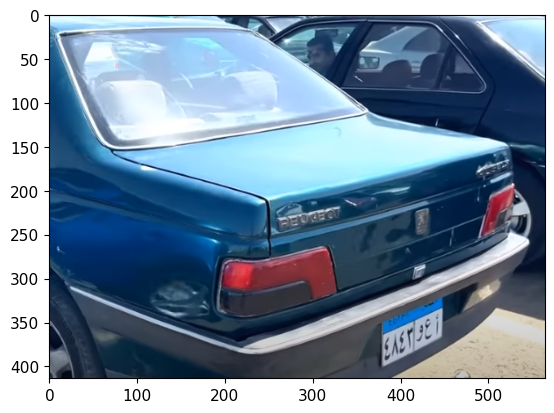

In [34]:
show_image_and_final_result(images)